In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype as Category
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
import numpy as np
from iterextras import par_for
import subprocess as sp
import os
import itertools
from tqdm.auto import tqdm
import rs_utils

sns.set()

In [2]:
def cond(df, m=None, c=None, p=None):
    if m is not None:
        df = df[df.mutability_mode == m]
    if c is not None:
        df = df[df.context_mode == c]
    if p is not None:
        df = df[df.pointer_mode == p]
    return df

In [3]:
PATHS = glob('../data/*.json')
CRATES = [os.path.splitext(os.path.basename(path))[0] for path in PATHS]
CATEGORIES = {
    'mutability_mode': Category(["DistinguishMut", "IgnoreMut"]),
    'context_mode': Category(["Recurse", "SigOnly"]),
    'pointer_mode': Category(["Conservative", "Precise"]),
    'crate': Category(CRATES)
}

def parse_data(path):
    print(path)
    if os.stat(path).st_size == 0:
        return []
    
    crate = os.path.splitext(os.path.basename(path))[0]
    df = pd.DataFrame(rs_utils.parse_data(path))
    df['crate'] = crate
    for k, dt in CATEGORIES.items():
        df[k] = df[k].astype(dt)
    return df


all_dfs = par_for(parse_data, PATHS)
df = pd.concat(all_dfs).reset_index()
del all_dfs

# df = df[(df.num_relevant_instructions != 0)]
df['ins_rel_nonzero'] = df.instructions_relative > 0

../data/rav1e.json
../data/hyper.json
../data/image.json
../data/RustPython.json
../data/rg3d.json
../data/rayon.json../data/rustls.json

../data/Rocket.json
../data/nalgebra.json
../data/sccache.json


  0%|          | 0/10 [00:00<?, ?it/s]

In [4]:
len(df.function_path.unique())

14696

In [5]:
len(df)/8

428183.0

In [6]:
df['ins_rel_frac_log'] = np.log(df.instructions_relative_frac)

/raid/wcrichto/flowistry-experiments/.env/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
df2 = cond(df, m='DistinguishMut', c='Recurse', p='Precise')
row = df2[df2.instructions_relative_frac > 0].iloc[0]
(row.function_path, row.sliced_local)

('rav1e[e9b6]::transform::forward::rust::forward_transform', 55)

In [8]:
df[(df.function_path == 'nalgebra[aca9]::linalg::cholesky::{impl#2}::xx_rank_one_update') & (df.sliced_local == 110)]

,index,mutability_mode,context_mode,pointer_mode,sliced_local,function_range,function_path,num_instructions,num_relevant_instructions,duration,...,has_same_type_ptrs_in_input,reached_library,instructions_relative,instructions_relative_frac,instructions_relative_base,instructions_relative_base_frac,baseline_reached_library,crate,ins_rel_nonzero,ins_rel_frac_log
3005032,74552,DistinguishMut,Recurse,Precise,110,"{'start': 12481, 'end': 14368, 'filename': 'sr...",nalgebra[aca9]::linalg::cholesky::{impl#2}::xx...,169,22,0.000010,...,False,False,0,0.000000,0,0.000000,False,nalgebra,False,-inf
3005033,74553,DistinguishMut,Recurse,Conservative,110,"{'start': 12481, 'end': 14368, 'filename': 'sr...",nalgebra[aca9]::linalg::cholesky::{impl#2}::xx...,169,61,0.000008,...,False,False,39,1.772727,39,1.772727,False,nalgebra,True,0.572519
3005034,74554,DistinguishMut,SigOnly,Precise,110,"{'start': 12481, 'end': 14368, 'filename': 'sr...",nalgebra[aca9]::linalg::cholesky::{impl#2}::xx...,169,22,0.001140,...,False,False,0,0.000000,0,0.000000,False,nalgebra,False,-inf
3005035,74555,DistinguishMut,SigOnly,Conservative,110,"{'start': 12481, 'end': 14368, 'filename': 'sr...",nalgebra[aca9]::linalg::cholesky::{impl#2}::xx...,169,67,0.001220,...,False,False,45,2.045455,45,2.045455,False,nalgebra,True,0.715620
3005036,74556,IgnoreMut,Recurse,Precise,110,"{'start': 12481, 'end': 14368, 'filename': 'sr...",nalgebra[aca9]::linalg::cholesky::{impl#2}::xx...,169,25,0.000008,...,False,False,3,0.136364,3,0.136364,False,nalgebra,True,-1.992430
3005037,74557,IgnoreMut,Recurse,Conservative,110,"{'start': 12481, 'end': 14368, 'filename': 'sr...",nalgebra[aca9]::linalg::cholesky::{impl#2}::xx...,169,71,0.000008,...,False,False,49,2.227273,49,2.227273,False,nalgebra,True,0.800778
3005038,74558,IgnoreMut,SigOnly,Precise,110,"{'start': 12481, 'end': 14368, 'filename': 'sr...",nalgebra[aca9]::linalg::cholesky::{impl#2}::xx...,169,25,0.001165,...,False,False,3,0.136364,3,0.136364,False,nalgebra,True,-1.992430
3005039,74559,IgnoreMut,SigOnly,Conservative,110,"{'start': 12481, 'end': 14368, 'filename': 'sr...",nalgebra[aca9]::linalg::cholesky::{impl#2}::xx...,169,78,0.001245,...,False,False,56,2.545455,56,2.545455,False,nalgebra,True,0.934309


# Dataset summary

In [9]:
#df2 = df.groupby(['crate', 'function_path']).apply(compute_loc)#.groupby('crate').sum()
g = df2.reset_index().groupby('crate')
out = g.sum()
out['size'] = g.size()
out

,level_0,index,sliced_local,num_instructions,num_relevant_instructions,duration,has_immut_ptr_in_call,has_same_type_ptrs_in_call,has_same_type_ptrs_in_input,reached_library,instructions_relative,instructions_relative_frac,instructions_relative_base,instructions_relative_base_frac,baseline_reached_library,ins_rel_nonzero,ins_rel_frac_log,size
crate,,,,,,,,,,,,,,,,,,
rav1e,24839336024,24839336024,53244787,138040982,14295519,40207.988802,65126,13231,3403,43236,479,29.216987,1.391253e+23,3.209171e+21,43236,7,NaN,78803
hyper,31608246544,6396960360,10416026,31102644,4589675,14146.964126,37544,33294,0,22108,0,0.000000,7.909964e+22,2.036313e+21,22108,0,NaN,39991
image,45251540840,6612129224,3026040,9216838,1415070,166.056113,32727,5083,99,16480,0,0.000000,5.130040e+22,1.356555e+21,16480,0,NaN,40658
RustPython,165535077400,39221029848,10932016,40536630,2445765,1671.396758,96737,5358,0,73846,0,0.000000,1.815344e+23,1.487545e+22,73846,0,NaN,99022
rg3d,140612798832,14806265760,4329061,12615406,2406495,396.121521,45790,2469,199,28451,0,0.000000,1.303262e+23,3.566369e+21,28451,0,NaN,60841
rayon,27778080720,457489320,235327,729025,189531,31.106423,7263,1999,138,6155,0,0.000000,7.673846e+21,1.279245e+21,6155,0,NaN,10695
rustls,64774116960,2243822160,1505658,4790435,706052,206.211476,21598,8067,384,15990,971,7.648764,5.641014e+22,2.374486e+21,15990,157,NaN,23685
Rocket,36331401840,636502440,1091190,2954112,177584,211.993995,10778,824,0,9394,0,0.000000,6.419467e+21,1.189334e+21,9394,0,NaN,12615
nalgebra,114536154960,5534020880,2849840,7473922,1094409,68.393510,34251,481,110,20894,0,0.000000,9.035215e+22,6.395109e+21,20894,0,NaN,37196


## Execution time

In [10]:
df2 = cond(df, m='DistinguishMut', c='SigOnly', p='Precise')
print(df2.duration.max(), df2.duration.median() * 100000)


6.131201465200001 57.37436999999999


In [11]:
df2 = cond(df, m='IgnoreMut', c='Recurse', p='Conservative')
print(df2.duration.max(), df2.duration.median() * 100000)

29.2166504726 8.962150000000001


## Number of instructions

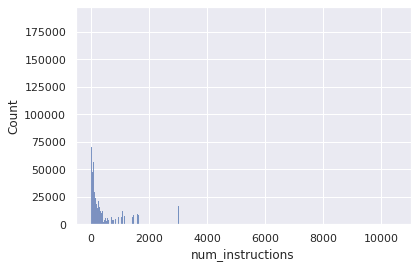

In [12]:
ax = sns.histplot(df.num_instructions)
# ax.set_xscale('log')

In [13]:
df_big = df[df.num_instructions >= 1000]
len(df_big) / len(df)

0.13458497885249998

# Exploration

In [14]:
df2 = cond(df, c='SigOnly', m='DistinguishMut', p='Precise')
nz = df2[(df2.instructions_relative_frac > 0) & (df2.sliced_local < 3) & (df2.crate == 'Rocket')]
nz[20:40][['function_path', 'sliced_local', 'num_instructions']]
# nz.sort_values('instructions_relative_frac', ascending=False)


,function_path,sliced_local,num_instructions
2853538,rocket[b030]::async_main,2,31
2853834,rocket[b030]::router::router::{impl#0}::finalize,0,52
2853898,rocket[b030]::rocket::{impl#0}::ignite,0,5
2854906,rocket[b030]::response::status::{impl#5}::resp...,0,49
2856298,rocket[b030]::form::field::{impl#1}::unexpected,0,12
2859394,rocket[b030]::form::from_form::{impl#3}::init,0,13
2859978,rocket[b030]::response::status::{impl#9}::resp...,0,34
2861106,rocket[b030]::form::field::{impl#0}::unexpected,0,15
2862138,rocket[b030]::form::error::{impl#8}::with_entity,0,8
2862194,rocket[b030]::response::responder::{impl#10}::...,0,88



# Slice size analysis

In [15]:
def plot_ins(data, xscale='linear', yscale='linear', field='instructions_relative_frac', nz=True, ax=None, **kwargs):
    if xscale == 'log':
        df_plot = data[data.ins_rel_nonzero]
        bins = np.logspace(np.log10(0.00001), np.log10(df_plot[field].max()))
    elif xscale == 'symlog':
        df_plot = data
        min_n = df_plot[df_plot[field] > 0][field].min()/10
        bins = np.concatenate(([0], np.logspace(np.log10(min_n), np.log10(df_plot[field].max()))))
    else:
        df_plot = data
        n = df_plot.instructions_relative_frac.max()
        bins = np.arange(0, n, n / 50)
        
    ax = sns.histplot(df_plot[field], bins=bins, ax=ax) #element='step')
    ax.set_yscale(yscale)
    if xscale == 'symlog':
        ax.set_xscale(xscale, linthresh=min_n, linscale=0.2)
    else:
        ax.set_xscale(xscale)
        
    ax.set_xlabel('\% diff in slice size' + (', log scale' if 'log' in xscale else ''))
    ax.set_ylabel('Count' + (', log scale' if yscale == 'log' else ''))
    
    if xscale == 'log' and nz:
        n = data[data.ins_rel_nonzero][field].min() / 10
        ax.bar(n, len(data[~data.ins_rel_nonzero]), color='r', width=[n])
    elif xscale == 'symlog':
        ax.set_xlim(0)
        xticks = ax.get_xticks()
        ax.set_xticks(np.concatenate((xticks[0:1], xticks[3:])))
        
plot_ins_nz = lambda *args, **kwargs: plot_ins(*args, xscale='log', yscale='linear', nz=False, **kwargs)
plot_ins_abs = lambda *args, **kwargs: plot_ins(*args, field='instructions_relative', **kwargs)

# plot_ins(df, 'symlog', 'log')

/raid/wcrichto/flowistry-experiments/.env/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


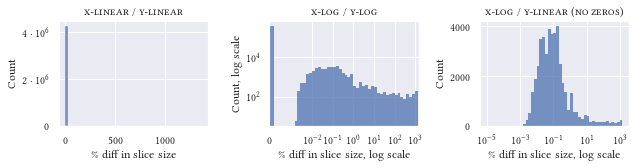

In [16]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Linux Libertine O']})
rc('text', **{'usetex': True, 'latex.preamble': r'\usepackage{libertine}\usepackage[libertine]{newtxmath}'})

df2 = cond(df, c='SigOnly', m='DistinguishMut', p='Precise')
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(9, 2.5))
plot_ins(df2, ax=ax1)
ax1.set_title('\\textsc{x-linear / y-linear}')
ax1.set_yticklabels(['0', '$2 \cdot 10^6$', '$4 \cdot 10^6$'])

plot_ins(df2, xscale='symlog', yscale='log', ax=ax2)
ax2.set_title('\\textsc{x-log / y-log}')
plot_ins(df2, xscale='log', nz=False, ax=ax3)
ax3.set_title('\\textsc{x-log / y-linear (no zeros)}')
ax3.set_xticks([10e-6, 10e-4, 10e-2, 10e-0, 10e2])

# fig.suptitle('Distribution of slice \%diff for SigOnly vs. Recurse')
fig.tight_layout()
fig.savefig('eval-recurse-dist.pdf')

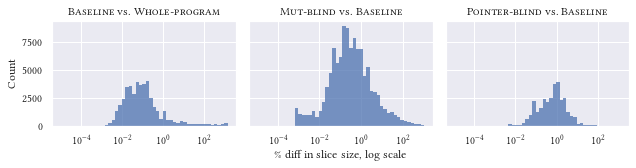

In [17]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(9, 2.5), sharey=True)

plot_ins(cond(df, c='SigOnly', m='DistinguishMut', p='Precise'), xscale='log', nz=False, ax=ax1)
ax1.set_title('\\textsc{Baseline} vs. \\textsc{Whole-program}')
plot_ins(cond(df, c='SigOnly', m='IgnoreMut', p='Precise'), field='instructions_relative_base_frac', 
         xscale='log', nz=False, ax=ax2)
ax2.set_title('\\textsc{Mut-blind} vs. \\textsc{Baseline}')
plot_ins(cond(df, c='SigOnly', m='DistinguishMut', p='Conservative'), field='instructions_relative_base_frac', 
         xscale='log', nz=False, ax=ax3)
ax3.set_title('\\textsc{Pointer-blind} vs. \\textsc{Baseline}')

ax1.set_xlabel('')
ax3.set_xlabel('')

fig.tight_layout()

fig.savefig('eval-all-dist.pdf')

In [18]:
df2 = cond(df, c='SigOnly', m='IgnoreMut', p='Precise')
g = df2[df2.instructions_relative_base_frac > 0].groupby('crate').size().rename('nz')
g2 = pd.concat([
    g, 
    df2.groupby('crate').size().rename('total'), 
    df2.groupby('crate').num_instructions.median().rename('avg_ins')], axis=1)
g2['frac'] = g2.nz / g2.total
g2.sort_values('frac')

,nz,total,avg_ins,frac
crate,,,,
rayon,762,10695,24.0,0.071248
image,5966,40658,133.0,0.146736
Rocket,2055,12615,75.0,0.162901
rg3d,10667,60841,85.0,0.175326
RustPython,20073,99022,113.0,0.202713
rustls,5453,23685,108.0,0.230230
sccache,7924,24677,203.0,0.321109
nalgebra,12028,37196,80.0,0.323368
rav1e,26927,78803,427.0,0.341700


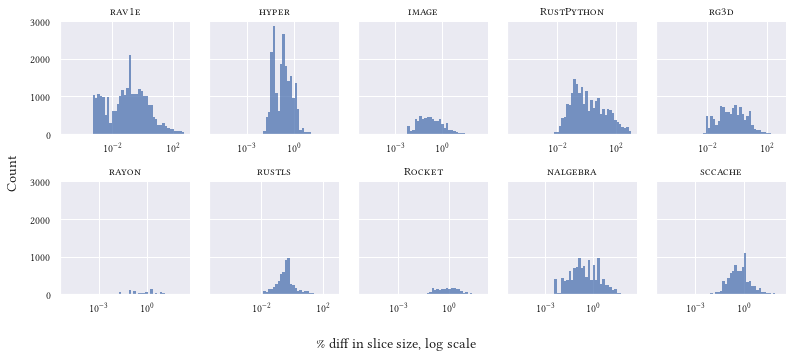

In [19]:
g = sns.FacetGrid(data=cond(df, c='SigOnly', m='IgnoreMut', p='Precise'), 
                  col='crate', col_wrap=5, sharex=False, height=2.5, aspect=0.9)
g.map_dataframe(plot_ins, xscale='log', nz=False, field='instructions_relative_base_frac')
g.set_titles('\\textsc{{{col_name}}}')
g.fig.supylabel('Count')
g.fig.supxlabel('\% diff in slice size, log scale')
g.fig.tight_layout()
g.fig.savefig('eval-crates.pdf')

In [26]:
df2 = cond(df, c='SigOnly', m='DistinguishMut', p='Precise')
nz = df2[df2.instructions_relative_frac > 0]
print(len(nz) / len(df2), gmean(nz.instructions_relative_frac))

0.10194239378957128 0.10787878760446946


In [20]:
from scipy.stats.mstats import gmean

df2 = cond(df, c='SigOnly', m='IgnoreMut', p='Precise')
nz = df2[df2.instructions_relative_base_frac > 0]
print(len(nz) / len(df2), gmean(nz.instructions_relative_base_frac))

0.26238313991914675 0.30609799147819794


In [21]:
df2 = cond(df, c='SigOnly', m='DistinguishMut', p='Conservative')
nz = df2[df2.instructions_relative_base_frac > 0]
print(len(nz) / len(df2), gmean(nz.instructions_relative_base_frac))

0.07040214114058709 0.609724806978935


In [22]:
cond(df, c='Recurse', m='DistinguishMut', p='Precise').groupby('reached_library').num_instructions.describe()

,count,mean,std,min,25%,50%,75%,max
reached_library,,,,,,,,
False,176920.0,351.538226,512.192221,2.0,35.0,153.0,445.0,3375.0
True,251263.0,770.780421,1964.937373,3.0,55.0,145.0,458.0,10485.0


In [23]:
cond(df, c='SigOnly', m='DistinguishMut', p='Precise').groupby(['reached_library', 'ins_rel_nonzero']) \
    .instructions_relative_frac.describe()[['count', 'mean', '50%']]

count       mean       50%
reached_library ins_rel_nonzero                               
False           False            158568.0   0.000000  0.000000
                True              18352.0  29.866936  0.111111
True            False            225965.0   0.000000  0.000000
                True              25298.0   3.133369  0.061224

In [24]:
print(732 / 139695)
print(18267.0 / 258263.0)

0.005239987114785783
0.07073022461599222


In [25]:
# df2 = cond(df, c='SigOnly', m='DistinguishMut', p='Precise')
# df3 = df2.groupby(['crate', 'function_path']) \
#     .apply(lambda df: df.iloc[0]).reset_index(drop=True)
num_slices = df2.groupby(['crate']).size().rename('num_slices')
avg_ins_per_func = df3.groupby('crate').num_instructions.mean() \
    .rename('avg_ins_per_func')
num_funcs = df2.groupby(['crate']).size().rename('num_funcs')

q = df2.groupby(['crate', 'function_path']).size()
avg_slices_per_func = q[q > 0] \
    .groupby('crate').mean().rename('avg_slices_per_func')
pd.concat(
    [num_slices, avg_ins_per_func, num_funcs, avg_slices_per_func], 
    axis=1).sort_values('num_slices')

NameError: name 'df3' is not defined